In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from __future__ import division, print_function

import collections
import csv
import datetime
import xml.etree.ElementTree as ET

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline

from GlucNet_functions import *

In [3]:
filepath = f"../OhioT1DM/2018/train/559-ws-training.xml"
tree = ET.parse(filepath)
root = tree.getroot()
glucose = read_ohio(filepath, "glucose_level", False)

# Preprocessing

#### P1

In [4]:
glucose_dict = {entry[0]['ts']: entry[0]['value'] for entry in glucose}

# Create the multi-channel database
g_data = []
for timestamp in glucose_dict:
    record = {
        'timestamp': timestamp,
        'glucose_value': glucose_dict[timestamp],
        # 'meal_type': None,
        # 'meal_carbs': 0
    }
    
    g_data.append(record)
glucose_df = pd.DataFrame(g_data)

# Convert glucose values to numeric type for analysis
glucose_df['glucose_value'] = pd.to_numeric(glucose_df['glucose_value'])

# Calculate percentiles
lower_percentile = np.percentile(glucose_df['glucose_value'], 2)
upper_percentile = np.percentile(glucose_df['glucose_value'], 98)

# Print thresholds
print(f"2% lower threshold: {lower_percentile}")
print(f"98% upper threshold: {upper_percentile}")

2% lower threshold: 64.0
98% upper threshold: 337.0


In [5]:
glucose_df['timestamp'].describe()

count                            10796
mean     2021-12-28 04:05:26.771026176
min                2021-12-07 01:17:00
25%                2021-12-17 15:41:45
50%                2021-12-28 13:12:30
75%                2022-01-07 12:52:15
max                2022-01-17 23:56:00
Name: timestamp, dtype: object

### P2, P3

In [6]:
segments = segement_data_as_1hour(glucose_df)
interpolated_segements = detect_missing_and_spline_interpolate(segments)

segment_3
before:  2021-12-12 04:54:00
after:  2021-12-12 05:29:00
segment_3
before:  2021-12-12 12:34:00
after:  2021-12-12 12:44:00
segment_3
before:  2021-12-12 22:09:00
after:  2021-12-12 22:39:00
segment_7
before:  2021-12-16 17:53:00
after:  2021-12-16 18:18:00
segment_14
before:  2021-12-22 17:52:00
after:  2021-12-22 18:52:00
segment_14
before:  2021-12-24 17:52:00
after:  2021-12-24 18:32:00
segment_15
before:  2021-12-26 18:57:00
after:  2021-12-26 19:22:00
segment_18
before:  2022-01-01 20:50:00
after:  2022-01-01 21:10:00
segment_21
before:  2022-01-06 06:26:00
after:  2022-01-06 07:21:00
segment_25
before:  2022-01-08 18:05:00
after:  2022-01-08 18:40:00
segment_29
before:  2022-01-14 01:05:00
after:  2022-01-14 01:35:00
segment_31
before:  2022-01-16 19:11:00
after:  2022-01-16 19:56:00


In [7]:
meal = read_ohio(filepath, "meal", False)

flattened_meal_data = [item[0] for item in meal]  # Take the first (and only) item from each sublist

# Convert to DataFrame
meal_df = pd.DataFrame(flattened_meal_data)

meal_df['assigned'] = False

meal_updated_segments = update_segments_with_meals(interpolated_segements, meal_df)


c:\Users\Biratal\Desktop\Dartmouth\HealthX\ReproGenBG_ML4H\GluNet_Again\GlucNet_functions.py:421: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '18' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  segment_df.at[i, 'carbs'] = closest_meal['carbs']
c:\Users\Biratal\Desktop\Dartmouth\HealthX\ReproGenBG_ML4H\GluNet_Again\GlucNet_functions.py:421: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '45' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  segment_df.at[i, 'carbs'] = closest_meal['carbs']
c:\Users\Biratal\Desktop\Dartmouth\HealthX\ReproGenBG_ML4H\GluNet_Again\GlucNet_functions.py:421: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '63' has dtype incompatible with int64, please explicitly cast to a

In [8]:
basal = read_ohio(filepath, "basal", False)

flattened_basal_data = [item[0] for item in basal]  # Take the first (and only) item from each sublist

# Convert to DataFrame
basal_df = pd.DataFrame(flattened_basal_data)

basal_df['assigned'] = False
basal_df['end_ts'] = basal_df['ts'].shift(-1)
basal_df[:10]

,ts,value,assigned,end_ts
0,2021-12-07 00:00:00,0.65,False,2021-12-07 04:00:00
1,2021-12-07 04:00:00,0.73,False,2021-12-07 08:00:00
2,2021-12-07 08:00:00,1.15,False,2021-12-07 11:00:00
3,2021-12-07 11:00:00,0.9,False,2021-12-08 00:00:00
4,2021-12-08 00:00:00,0.65,False,2021-12-08 04:00:00
5,2021-12-08 04:00:00,0.73,False,2021-12-08 08:00:00
6,2021-12-08 08:00:00,1.15,False,2021-12-08 11:00:00
7,2021-12-08 11:00:00,0.9,False,2021-12-08 18:00:00
8,2021-12-08 18:00:00,1.25,False,2021-12-11 00:00:00
9,2021-12-11 00:00:00,0.65,False,2021-12-11 04:00:00


In [9]:
basal_updated_segments = update_segments_with_basal(meal_updated_segments, basal_df)


In [10]:
# Merge Bolus into the dataframe
bolus = read_ohio_bolus_tempbasal(filepath, "bolus", False)

flattened_bolus_data = [item[0] for item in bolus]  # Take the first (and only) item from each sublist

# Convert to DataFrame
bolus_df = pd.DataFrame(flattened_bolus_data)

bolus_df['assigned'] = False
bolus_df[:10]

,ts_begin,ts_end,type,dose,bwz_carb_input,assigned
0,2021-12-07 01:08:04,2021-12-07 01:08:04,normal,1.6,25,False
1,2021-12-07 11:21:49,2021-12-07 11:21:49,normal,9.3,0,False
2,2021-12-07 23:50:34,2021-12-07 23:50:34,normal,3.8,0,False
3,2021-12-08 05:11:38,2021-12-08 05:11:38,normal,4.1,45,False
4,2021-12-08 11:27:23,2021-12-08 11:27:23,normal,6.3,63,False
5,2021-12-08 19:06:34,2021-12-08 19:06:34,normal,2.2,20,False
6,2021-12-09 02:05:46,2021-12-09 02:05:46,normal,0.6,0,False
7,2021-12-09 08:20:50,2021-12-09 08:20:50,normal,4.2,0,False
8,2021-12-09 13:15:16,2021-12-09 13:15:16,normal,2.0,20,False
9,2021-12-09 15:03:10,2021-12-09 15:03:10,normal,4.5,45,False


In [11]:
bolus_updated_segments = update_segments_with_bolus(basal_updated_segments, bolus_df)

KeyboardInterrupt: 

In [ ]:
tempbasal = read_ohio_bolus_tempbasal(filepath, "temp_basal", False)

In [ ]:
flattened_tempbasal_data = [item[0] for item in tempbasal]  # Take the first (and only) item from each sublist

# Convert to DataFrame
tempbasal_df = pd.DataFrame(flattened_tempbasal_data)

tempbasal_df['assigned'] = False
tempbasal_df[:10]

,ts_begin,ts_end,value,assigned
0,2021-12-07 04:49:28,2021-12-07 05:08:39,0.0,False
1,2021-12-07 17:01:44,2021-12-07 18:03:20,0.0,False
2,2021-12-08 15:12:19,2021-12-08 16:12:27,0.0,False
3,2021-12-09 11:11:10,2021-12-09 12:19:17,0.0,False
4,2021-12-10 14:14:00,2021-12-10 16:14:00,0.0,False
5,2021-12-10 19:51:28,2021-12-10 21:30:37,0.0,False
6,2021-12-11 17:25:48,2021-12-11 18:10:10,0.0,False
7,2021-12-15 01:32:00,2021-12-15 03:30:00,0.0,False
8,2021-12-17 20:24:00,2021-12-17 22:24:00,0.0,False
9,2021-12-22 19:52:33,2021-12-22 21:52:00,0.0,False


In [ ]:


# Update the segments with meal data
final_updated_segments = update_segments_with_tempbasal(bolus_updated_segments, tempbasal_df)

In [ ]:
final_updated_segments['segment_1']

,timestamp,glucose_value,carbs,basal_rate,bolus_dose
0,2021-12-07 01:17:00,101,0,0.65,0
1,2021-12-07 01:22:00,98,0,0.65,0
2,2021-12-07 01:27:00,104,0,0.65,0
3,2021-12-07 01:32:00,112,0,0.65,0
4,2021-12-07 01:37:00,120,0,0.65,0
...,...,...,...,...,...
223,2021-12-07 19:52:00,96,0,0.9,0
224,2021-12-07 19:57:00,93,0,0.9,0
225,2021-12-07 20:02:00,86,0,0.9,0
226,2021-12-07 20:07:00,86,0,0.9,0


# Training

In [ ]:
import torch
from torch.utils.data import DataLoader, TensorDataset

In [ ]:
def label_delta_transform(labels_list):
    # label_lower_percentile = -12.75
    # label_upper_percentile = 12.85
    label_lower_percentile = np.percentile(labels_list, 10)
    label_upper_percentile = np.percentile(labels_list, 90)
    transformed_labels = []
    for label in labels_list:
        if label <= label_lower_percentile:
            transformed_labels.append(1)
        elif label_lower_percentile < label < label_upper_percentile:
            trans_label = round((256/(label_upper_percentile - label_lower_percentile))*(label + abs(label_lower_percentile) + 0.05))
            transformed_labels.append(trans_label)
        elif label >= label_upper_percentile:
            transformed_labels.append(256)
    return transformed_labels


# def prepare_dataset(segments, ph):
#     '''
#     ph = 6, 30 minutes ahead
#     ph = 12, 60 minutes ahead
#     '''
#     features_list = []
#     labels_list = []
#     raw_glu_list = []
    
#     # Iterate over each segment
#     for segment_name, segment_df in segments.items():
#         # Ensure all columns are of numeric type
#         segment_df['carbs'] = pd.to_numeric(segment_df['carbs'], errors='coerce')
#         segment_df['basal_rate'] = pd.to_numeric(segment_df['basal_rate'], errors='coerce')
#         segment_df['bolus_dose'] = pd.to_numeric(segment_df['bolus_dose'], errors='coerce')

#         # Fill NaNs that might have been introduced by conversion errors
#         segment_df.fillna(0, inplace=True)

#         # Maximum index for creating a complete feature set
#         max_index = len(segment_df) - (15+ph+1)  # Subtracting 22 because we need to predict index + 21 and need index + 15 to exist
        
#         # Iterate through the data to create feature-label pairs
#         for i in range(max_index + 1):
#             # Extracting features from index i to i+15
#             features = segment_df.loc[i:i+15, ['glucose_value', 'carbs', 'basal_rate', 'bolus_dose']].values#.flatten()
#             # Extracting label for index i+21
#             # Do the label transform
#             label = segment_df.loc[i+15+ph, 'glucose_value'] - segment_df.loc[i+15, 'glucose_value']
            
#             raw_glu_list.append(segment_df.loc[i+15+ph, 'glucose_value'])
#             features_list.append(features)
#             labels_list.append(label)
            
#     print("len of features_list " + str(len(features_list)))
#     print("len of labels_list " + str(len(labels_list)))
#     new_labels_list = label_delta_transform(labels_list)    
#     print("after label transform. the len of label list "+str(len(new_labels_list)))    
#     return features_list, labels_list, new_labels_list, raw_glu_list

def prepare_dataset(segments, ph):
    '''
    ph = 6, 30 minutes ahead
    ph = 12, 60 minutes ahead
    '''
    features_list = []
    labels_list = []
    raw_glu_list = []
    
    history_len = 15
    
    # Iterate over each segment
    for segment_name, segment_df in segments.items():
        # Ensure all columns are of numeric type
        segment_df['carbs'] = pd.to_numeric(segment_df['carbs'], errors='coerce')
        segment_df['basal_rate'] = pd.to_numeric(segment_df['basal_rate'], errors='coerce')
        segment_df['bolus_dose'] = pd.to_numeric(segment_df['bolus_dose'], errors='coerce')

        # Fill NaNs that might have been introduced by conversion errors
        segment_df.fillna(0, inplace=True)

        # Maximum index for creating a complete feature set
        print("len of segment_df is ", len(segment_df))
        max_index = len(segment_df) - (history_len + ph)  # Subtracting only 15+ph to ensure i + 15 + ph is within bounds
        
        # Iterate through the data to create feature-label pairs
        for i in range(max_index):
            # Extracting features from index i to i+15
            segment_df = segment_df.reset_index(drop = True)
            features = segment_df.loc[i:i+history_len, ['glucose_value', 'carbs', 'basal_rate', 'bolus_dose']].values
            # Extracting label for index i+15+ph
            # label = segment_df.loc[i+15+ph, 'glucose_value'] - segment_df.loc[i+15, 'glucose_value']
            
            raw_glu_list.append(segment_df.loc[i+history_len+ph, 'glucose_value'])
            features_list.append(features)
            # labels_list.append(label)
            
    print("len of features_list " + str(len(features_list)))
    # print("len of labels_list " + str(len(labels_list)))
    
    # new_labels_list = label_delta_transform(labels_list)    
    # print("after label transform, the len of label list "+str(len(new_labels_list)))    
    
    return features_list, raw_glu_list


In [ ]:
features_array = np.array(features_list)
labels_array = np.array(labels_list)

features_array.shape

(10215, 16, 4)

In [ ]:


# Step 1: Split into 80% train+val and 20% test
X_temp, X_test, y_temp, y_test = train_test_split(features_array, labels_array, test_size=0.2, shuffle=False)

# Step 2: Split the 80% into 70% train and 10% val (0.7/0.8 = 0.875)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.125, shuffle=False)

# Convert the splits to torch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

# Create DataLoaders
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)

val_dataset = TensorDataset(X_val, y_val)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [ ]:
# Convert lists to PyTorch tensors
features_tensor = torch.tensor(features_list, dtype=torch.float32)
labels_tensor = torch.tensor(labels_list, dtype=torch.float32).unsqueeze(1)  # Making labels tensor 2D

feature_label_tensor = TensorDataset(features_tensor, labels_tensor)


train_loader = DataLoader(feature_label_tensor, batch_size=32, shuffle=True)

# Example of using DataLoader in a training loop
for features, labels in train_loader:
    print("Features batch shape:", features.shape)
    print("Label batch shape:", labels.shape)
    # Example: print(features, labels)
    break

Features batch shape: torch.Size([32, 16, 4])
Label batch shape: torch.Size([32, 1])


C:\Users\Biratal\AppData\Local\Temp\ipykernel_66536\3199413937.py:2: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:264.)
  features_tensor = torch.tensor(features_list, dtype=torch.float32)


In [40]:
def prepare_training_dataset(file_dir): 
    filepath = file_dir
    tree = ET.parse(filepath)
    root = tree.getroot()
    glucose = read_ohio(filepath, "glucose_level", False)
    glucose_dict = {entry[0]['ts']: entry[0]['value'] for entry in glucose}

    # Create the multi-channel database
    g_data = []
    for timestamp in glucose_dict:
        record = {
            'timestamp': timestamp,
            'glucose_value': glucose_dict[timestamp],
            # 'meal_type': None,
            # 'meal_carbs': 0
        }
        
        g_data.append(record)
    glucose_df = pd.DataFrame(g_data)

    # Convert glucose values to numeric type for analysis
    glucose_df['glucose_value'] = pd.to_numeric(glucose_df['glucose_value'])
    segments = segement_data_as_1hour(glucose_df)
    interpolated_segements = detect_missing_and_spline_interpolate(segments)
    
    meal = read_ohio(filepath, "meal", False)

    flattened_meal_data = [item[0] for item in meal]  # Take the first (and only) item from each sublist

    # Convert to DataFrame
    meal_df = pd.DataFrame(flattened_meal_data)

    meal_df['assigned'] = False

    meal_updated_segments = update_segments_with_meals(interpolated_segements, meal_df)

    basal = read_ohio(filepath, "basal", False)

    flattened_basal_data = [item[0] for item in basal]  # Take the first (and only) item from each sublist

    # Convert to DataFrame
    basal_df = pd.DataFrame(flattened_basal_data)

    basal_df['assigned'] = False
    basal_df['end_ts'] = basal_df['ts'].shift(-1)
    basal_updated_segments = update_segments_with_basal(meal_updated_segments, basal_df)
    
        # Merge Bolus into the dataframe
    bolus = read_ohio_bolus_tempbasal(filepath, "bolus", False)
    flattened_bolus_data = [item[0] for item in bolus]  # Take the first (and only) item from each sublist
    bolus_df = pd.DataFrame(flattened_bolus_data)
    bolus_df['assigned'] = False
    bolus_updated_segments = update_segments_with_bolus(basal_updated_segments, bolus_df)

    tempbasal = read_ohio_bolus_tempbasal(filepath, "temp_basal", False)
    flattened_tempbasal_data = [item[0] for item in tempbasal]  
    tempbasal_df = pd.DataFrame(flattened_tempbasal_data)

    tempbasal_df['assigned'] = False

    # Update the segments with meal data
    final_updated_segments = update_segments_with_tempbasal(bolus_updated_segments, tempbasal_df)
    
    return final_updated_segments



In [25]:
import glob
import os 

directory_path = "../OhioT1DM/2018/train/"
xml_files = glob.glob(os.path.join(directory_path, "*-ws-training.xml"))
xml_files[0]

'559'

In [28]:
import glob
import os

def process_all_training_files(directory_path):
    # Get all XML files in the directory
    xml_files = glob.glob(os.path.join(directory_path, "*-ws-training.xml"))
    
    all_processed_data = []
    
    for filepath in xml_files:
        try:
            bolus = prepare_training_dataset(filepath)
            # Add to list of processed data
            file_name = f"dat_{filepath.split('-ws')[0][-3::]}.pkl"
            with open(file_name, 'wb') as f:
                pickle.dump(bolus, f)
                

            all_processed_data.append({
                'filepath': filepath,
                'segments': bolus
            })
            
            print(f"Successfully processed {filepath}")
            
        except Exception as e:
            print(f"Error processing {filepath}: {str(e)}")
    
    return all_processed_data

# Usage
directory_path = "../OhioT1DM/2018/train/"
training_data = process_all_training_files(directory_path)

segment_3
before:  2021-12-12 04:54:00
after:  2021-12-12 05:29:00
segment_3
before:  2021-12-12 12:34:00
after:  2021-12-12 12:44:00
segment_3
before:  2021-12-12 22:09:00
after:  2021-12-12 22:39:00
segment_7
before:  2021-12-16 17:53:00
after:  2021-12-16 18:18:00
segment_14
before:  2021-12-22 17:52:00
after:  2021-12-22 18:52:00
segment_14
before:  2021-12-24 17:52:00
after:  2021-12-24 18:32:00
segment_15
before:  2021-12-26 18:57:00
after:  2021-12-26 19:22:00
segment_18
before:  2022-01-01 20:50:00
after:  2022-01-01 21:10:00
segment_21
before:  2022-01-06 06:26:00
after:  2022-01-06 07:21:00
segment_25
before:  2022-01-08 18:05:00
after:  2022-01-08 18:40:00
segment_29
before:  2022-01-14 01:05:00
after:  2022-01-14 01:35:00
segment_31
before:  2022-01-16 19:11:00
after:  2022-01-16 19:56:00


c:\Users\Biratal\Desktop\Dartmouth\HealthX\ReproGenBG_ML4H\GluNet_Again\GlucNet_functions.py:421: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '18' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  segment_df.at[i, 'carbs'] = closest_meal['carbs']
c:\Users\Biratal\Desktop\Dartmouth\HealthX\ReproGenBG_ML4H\GluNet_Again\GlucNet_functions.py:421: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '45' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  segment_df.at[i, 'carbs'] = closest_meal['carbs']
c:\Users\Biratal\Desktop\Dartmouth\HealthX\ReproGenBG_ML4H\GluNet_Again\GlucNet_functions.py:421: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '63' has dtype incompatible with int64, please explicitly cast to a

Error processing ../OhioT1DM/2018/train\559-ws-training.xml: name 'bolus_updated_segments' is not defined
segment_1
before:  2021-09-13 18:18:00
after:  2021-09-13 18:38:00
segment_1
before:  2021-09-14 06:23:00
after:  2021-09-14 06:38:00
segment_2
before:  2021-09-21 03:08:00
after:  2021-09-21 03:38:00
segment_2
before:  2021-09-25 04:23:00
after:  2021-09-25 04:53:00
segment_3
before:  2021-09-28 23:28:00
after:  2021-09-28 23:58:00
segment_3
before:  2021-09-29 17:28:00
after:  2021-09-29 17:48:00
segment_6
before:  2021-10-05 18:15:00
after:  2021-10-05 18:35:00
segment_10
before:  2021-10-23 11:32:00
after:  2021-10-23 11:52:00
segment_10
before:  2021-10-25 16:02:00
after:  2021-10-25 16:27:00
segment_11
before:  2021-10-26 04:36:00
after:  2021-10-26 05:16:00
segment_11
before:  2021-10-27 03:11:00
after:  2021-10-27 03:21:00


c:\Users\Biratal\Desktop\Dartmouth\HealthX\ReproGenBG_ML4H\GluNet_Again\GlucNet_functions.py:421: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '40' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  segment_df.at[i, 'carbs'] = closest_meal['carbs']
c:\Users\Biratal\Desktop\Dartmouth\HealthX\ReproGenBG_ML4H\GluNet_Again\GlucNet_functions.py:421: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '20' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  segment_df.at[i, 'carbs'] = closest_meal['carbs']
c:\Users\Biratal\Desktop\Dartmouth\HealthX\ReproGenBG_ML4H\GluNet_Again\GlucNet_functions.py:421: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '15' has dtype incompatible with int64, please explicitly cast to a

Error processing ../OhioT1DM/2018/train\563-ws-training.xml: name 'bolus_updated_segments' is not defined
segment_1
before:  2021-12-07 22:14:00
after:  2021-12-07 22:34:00
segment_6
before:  2021-12-22 17:03:00
after:  2021-12-22 18:03:00
segment_6
before:  2021-12-22 20:18:00
after:  2021-12-22 20:28:00
segment_8
before:  2021-12-27 07:53:00
after:  2021-12-27 08:28:00
segment_9
before:  2022-01-02 07:32:00
after:  2022-01-02 08:27:00


c:\Users\Biratal\Desktop\Dartmouth\HealthX\ReproGenBG_ML4H\GluNet_Again\GlucNet_functions.py:421: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '65' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  segment_df.at[i, 'carbs'] = closest_meal['carbs']
c:\Users\Biratal\Desktop\Dartmouth\HealthX\ReproGenBG_ML4H\GluNet_Again\GlucNet_functions.py:421: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '100' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  segment_df.at[i, 'carbs'] = closest_meal['carbs']
c:\Users\Biratal\Desktop\Dartmouth\HealthX\ReproGenBG_ML4H\GluNet_Again\GlucNet_functions.py:421: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '85' has dtype incompatible with int64, please explicitly cast to 

Unequal: begin: 2021-12-07 07:41:58 end: 2021-12-07 08:11:58
Unequal: begin: 2021-12-07 18:34:32 end: 2021-12-07 19:04:32
Unequal: begin: 2021-12-08 06:18:52 end: 2021-12-08 06:48:52
Unequal: begin: 2021-12-08 12:09:16 end: 2021-12-08 12:39:16
Unequal: begin: 2021-12-08 16:50:52 end: 2021-12-08 17:20:52
Unequal: begin: 2021-12-08 19:26:31 end: 2021-12-08 19:56:31
Unequal: begin: 2021-12-08 21:36:59 end: 2021-12-08 22:06:59
Unequal: begin: 2021-12-09 06:29:18 end: 2021-12-09 06:59:18
Unequal: begin: 2021-12-09 12:04:48 end: 2021-12-09 12:34:48
Unequal: begin: 2021-12-09 19:42:56 end: 2021-12-09 20:12:56
Unequal: begin: 2021-12-10 06:11:17 end: 2021-12-10 06:41:17
Unequal: begin: 2021-12-10 13:31:26 end: 2021-12-10 14:01:26
Unequal: begin: 2021-12-10 19:59:05 end: 2021-12-10 20:29:05
Unequal: begin: 2021-12-11 09:26:02 end: 2021-12-11 09:56:02
Unequal: begin: 2021-12-11 16:57:23 end: 2021-12-11 17:27:23
Unequal: begin: 2021-12-11 20:20:42 end: 2021-12-11 20:50:42
Unequal: begin: 2021-12-

c:\Users\Biratal\Desktop\Dartmouth\HealthX\ReproGenBG_ML4H\GluNet_Again\GlucNet_functions.py:421: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '50' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  segment_df.at[i, 'carbs'] = closest_meal['carbs']
c:\Users\Biratal\Desktop\Dartmouth\HealthX\ReproGenBG_ML4H\GluNet_Again\GlucNet_functions.py:421: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '75' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  segment_df.at[i, 'carbs'] = closest_meal['carbs']
c:\Users\Biratal\Desktop\Dartmouth\HealthX\ReproGenBG_ML4H\GluNet_Again\GlucNet_functions.py:421: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '44' has dtype incompatible with int64, please explicitly cast to a

Unequal: begin: 2021-11-20 15:24:26 end: 2021-11-20 15:54:26
Unequal: begin: 2021-11-25 20:26:12 end: 2021-11-25 20:56:12
Unequal: begin: 2021-11-26 14:26:53 end: 2021-11-26 14:56:53
Unequal: begin: 2021-11-28 17:04:52 end: 2021-11-28 17:34:52
Unequal: begin: 2021-12-09 13:37:04 end: 2021-12-09 14:07:04
Unequal: begin: 2021-12-10 12:43:20 end: 2021-12-10 13:13:20
Unequal: begin: 2021-12-13 13:05:09 end: 2021-12-13 13:35:09
Unequal: begin: 2021-12-15 07:46:21 end: 2021-12-15 08:16:21
Unequal: begin: 2021-12-16 13:10:03 end: 2021-12-16 13:40:03
Unequal: begin: 2021-12-23 13:05:24 end: 2021-12-23 14:05:24
Error processing ../OhioT1DM/2018/train\575-ws-training.xml: name 'bolus_updated_segments' is not defined
segment_6
before:  2021-09-21 20:06:00
after:  2021-09-21 20:46:00


c:\Users\Biratal\Desktop\Dartmouth\HealthX\ReproGenBG_ML4H\GluNet_Again\GlucNet_functions.py:421: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '37' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  segment_df.at[i, 'carbs'] = closest_meal['carbs']
c:\Users\Biratal\Desktop\Dartmouth\HealthX\ReproGenBG_ML4H\GluNet_Again\GlucNet_functions.py:421: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '3' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  segment_df.at[i, 'carbs'] = closest_meal['carbs']
c:\Users\Biratal\Desktop\Dartmouth\HealthX\ReproGenBG_ML4H\GluNet_Again\GlucNet_functions.py:421: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '15' has dtype incompatible with int64, please explicitly cast to a 

Error processing ../OhioT1DM/2018/train\588-ws-training.xml: name 'bolus_updated_segments' is not defined
segment_1
before:  2021-12-02 03:06:00
after:  2021-12-02 03:36:00
segment_1
before:  2021-12-03 08:51:00
after:  2021-12-03 09:41:00
segment_1
before:  2021-12-04 19:11:00
after:  2021-12-04 19:41:00
segment_2
before:  2021-12-06 19:24:00
after:  2021-12-06 20:04:00
segment_3
before:  2021-12-09 18:08:00
after:  2021-12-09 18:28:00
segment_3
before:  2021-12-10 17:18:00
after:  2021-12-10 18:08:00
segment_3
before:  2021-12-11 19:13:00
after:  2021-12-11 19:58:00
segment_3
before:  2021-12-12 17:33:00
after:  2021-12-12 18:33:00
segment_4
before:  2021-12-17 17:30:00
after:  2021-12-17 17:50:00
segment_5
before:  2021-12-20 17:48:00
after:  2021-12-20 18:33:00
segment_5
before:  2021-12-22 10:33:00
after:  2021-12-22 11:03:00
segment_5
before:  2021-12-23 17:43:00
after:  2021-12-23 18:38:00
segment_7
before:  2022-01-02 00:25:00
after:  2022-01-02 00:35:00
segment_11
before:  202

c:\Users\Biratal\Desktop\Dartmouth\HealthX\ReproGenBG_ML4H\GluNet_Again\GlucNet_functions.py:421: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '60' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  segment_df.at[i, 'carbs'] = closest_meal['carbs']
c:\Users\Biratal\Desktop\Dartmouth\HealthX\ReproGenBG_ML4H\GluNet_Again\GlucNet_functions.py:421: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '13' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  segment_df.at[i, 'carbs'] = closest_meal['carbs']
c:\Users\Biratal\Desktop\Dartmouth\HealthX\ReproGenBG_ML4H\GluNet_Again\GlucNet_functions.py:421: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '18' has dtype incompatible with int64, please explicitly cast to a

Unequal: begin: 2022-01-09 11:43:23 end: 2022-01-09 12:13:23
Error processing ../OhioT1DM/2018/train\591-ws-training.xml: name 'bolus_updated_segments' is not defined


In [ ]:
# # create a dictionary such that the key is the segment number + i and the value is the segment data
# segment_dict = {}
# count = 0

# segment_name_list = []
# segment_data_list= []
# for i in training_data: 
#     count += 1
#     for j in i['segments']:
#         segment_dict[str(count)+j] = i['segments'][j]


In [ ]:
# # Save the processed data CAREFULL!!!
# # Specify the file name
import pickle
filename = './BIG_training_data_all_wavenet.pkl'
# Save the dictionary to a file
if not os.path.exists(filename):
    open(filename, 'wb').close()
# Save the dictionary to a file
with open(filename, 'wb') as f:
    pickle.dump(segment_dict, f)

In [ ]:
def prepare_dataset_test_dataset( file_dir = f'../OhioT1DM/2018/test/559-ws-testing.xml', ph = 6):
        # test data
    g_data = []

    print("file_dir is ", file_dir)
    test_file_path = file_dir 
    test_glucose = read_ohio(test_file_path, "glucose_level", False)
    test_glucose_dict = {entry[0]['ts']: entry[0]['value'] for entry in test_glucose}

    for timestamp in test_glucose_dict:
        record = {
            'timestamp': timestamp,
            'glucose_value': test_glucose_dict[timestamp],
        }
        
        g_data.append(record)
    test_glucose_df = pd.DataFrame(g_data)
    test_glucose_df['glucose_value'] = pd.to_numeric(test_glucose_df['glucose_value'])

    test_segmebts = segement_data_as_1hour(test_glucose_df)
    test_interpolated_segments = detect_missing_and_spline_interpolate(test_segmebts)

    test_meal = read_ohio(test_file_path, "meal", False)
    flattened_test_meal_data = [item[0] for item in test_meal]  # Take the first (and only) item from each sublist
    test_meal_df = pd.DataFrame(flattened_test_meal_data)
    test_meal_df['assigned'] = False
    test_meal_updated_segments = update_segments_with_meals(test_interpolated_segments, test_meal_df)

    test_basal = read_ohio(test_file_path, "basal", False)
    flattened_test_basal_data = [item[0] for item in test_basal]  # Take the first (and only) item from each sublist
    test_basal_df = pd.DataFrame(flattened_test_basal_data)
    test_basal_df['assigned'] = False
    test_basal_df['end_ts'] = test_basal_df['ts'].shift(-1)
    test_basal_updated_segments = update_segments_with_basal(test_meal_updated_segments, test_basal_df)

    test_bolus = read_ohio_bolus_tempbasal(test_file_path, "bolus", False)
    flattened_test_bolus_data = [item[0] for item in test_bolus]  # Take the first (and only) item from each sublist
    test_bolus_df = pd.DataFrame(flattened_test_bolus_data)
    test_bolus_df['assigned'] = False
    test_bolus_updated_segments = update_segments_with_bolus(test_basal_updated_segments, test_bolus_df)

    test_tempbasal = read_ohio_bolus_tempbasal(test_file_path, "temp_basal", False)
    flattened_test_tempbasal_data = [item[0] for item in test_tempbasal]  # Take the first (and only) item from each sublist
    test_tempbasal_df = pd.DataFrame(flattened_test_tempbasal_data)
    test_tempbasal_df['assigned'] = False

    test_final_updated_segments = update_segments_with_tempbasal(test_bolus_updated_segments, test_tempbasal_df)
    test_features_list, test_labels_list = prepare_dataset(test_final_updated_segments, ph)

    test_features_array = np.array(test_features_list)
    test_labels_array = np.array(test_labels_list)

    X_test, y_test = torch.tensor(test_features_array, dtype=torch.float32), torch.tensor(test_labels_array, dtype=torch.float32)

    test_dataset = TensorDataset(X_test, y_test)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    return test_loader

training_loader = prepare_dataset_test_dataset()

In [ ]:
# initialize cuda option
dtype = torch.FloatTensor # data type
ltype = torch.LongTensor # label type

use_cuda = torch.cuda.is_available()
if use_cuda:
    print('use gpu')
    dtype = torch.cuda.FloatTensor
    ltype = torch.cuda.LongTensor

use gpu


In [ ]:
# Build the dilate CNN
import torch
import torch.nn as nn
import torch.nn.functional as F

class WaveNetBlock(nn.Module):
    def __init__(self, in_channels, dilation):
        super(WaveNetBlock, self).__init__()
        self.conv1 = nn.Conv1d(in_channels, in_channels, kernel_size=2, dilation=dilation, padding=1+dilation - 2^(dilation-1))
        self.conv2 = nn.Conv1d(in_channels, in_channels, kernel_size=2, dilation=dilation, padding=dilation)
        self.res_conv = nn.Conv1d(in_channels, in_channels, kernel_size=1)
        
    def forward(self, x):
        # print("shape of x: ", x.shape)
        out = F.relu(self.conv1(x))
        # print("shape of first out: ", out.shape)
        out = F.relu(self.conv2(out))
        # print("shape of second out: ", out.shape)
        res = self.res_conv(x)
        # print("shape of res: ", res.shape)
        return out + res

class WaveNet(nn.Module):
    def __init__(self, in_channels, out_channels, num_blocks, dilations):
        super(WaveNet, self).__init__()
        self.initial_conv = nn.Conv1d(in_channels, 32, kernel_size=2, padding=1)
        self.blocks = nn.ModuleList([WaveNetBlock(32, dilation) for dilation in dilations])
        self.final_conv1 = nn.Conv1d(32, 128, kernel_size=2, padding=0)
        self.final_conv2 = nn.Conv1d(128, 256, kernel_size=2, padding=0)
        self.fc1 = nn.Linear(256, 128)
        self.fc2 = nn.Linear(128, out_channels)
        
    def forward(self, x):
        x = F.relu(self.initial_conv(x))
        for block in self.blocks:
            # print("enter the block loop")
            x = block(x)
        x = F.relu(self.final_conv1(x))
        x = F.relu(self.final_conv2(x))
        x = x[:, :, -1]  # Get the last time step
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

input_channels = 4  # Number of features
output_channels = 1  # Predicting a single value (glucose level)
num_blocks = 4  # Number of WaveNet blocks
dilations = [2**i for i in range(num_blocks)]  # Dilation rates: 1, 2, 4, 8

model = WaveNet(input_channels, output_channels, num_blocks, dilations)
print(model)

# Example of how to define the loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0008)


WaveNet(
  (initial_conv): Conv1d(4, 32, kernel_size=(2,), stride=(1,), padding=(1,))
  (blocks): ModuleList(
    (0): WaveNetBlock(
      (conv1): Conv1d(32, 32, kernel_size=(2,), stride=(1,))
      (conv2): Conv1d(32, 32, kernel_size=(2,), stride=(1,), padding=(1,))
      (res_conv): Conv1d(32, 32, kernel_size=(1,), stride=(1,))
    )
    (1): WaveNetBlock(
      (conv1): Conv1d(32, 32, kernel_size=(2,), stride=(1,), dilation=(2,))
      (conv2): Conv1d(32, 32, kernel_size=(2,), stride=(1,), padding=(2,), dilation=(2,))
      (res_conv): Conv1d(32, 32, kernel_size=(1,), stride=(1,))
    )
    (2): WaveNetBlock(
      (conv1): Conv1d(32, 32, kernel_size=(2,), stride=(1,), dilation=(4,))
      (conv2): Conv1d(32, 32, kernel_size=(2,), stride=(1,), padding=(4,), dilation=(4,))
      (res_conv): Conv1d(32, 32, kernel_size=(1,), stride=(1,))
    )
    (3): WaveNetBlock(
      (conv1): Conv1d(32, 32, kernel_size=(2,), stride=(1,), dilation=(8,))
      (conv2): Conv1d(32, 32, kernel_size=(2

In [ ]:
for inputs, targets in train_loader:
    print("Input tensor shape:", inputs.shape)
    print("Input tensor total elements:", inputs.numel())
    print("Target tensor shape:", targets.shape)
    print("Sequence length:", inputs.shape[1])
    break


Input tensor shape: torch.Size([32, 16, 4])
Input tensor total elements: 2048
Target tensor shape: torch.Size([32, 1])
Sequence length: 16


In [ ]:
inputs.shape

torch.Size([32, 16, 4])

In [ ]:

# Training Loop
num_epochs = 200
for epoch in range(num_epochs):
    model.train()
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs.permute(0, 2, 1))  # Permute to match (batch, channels, seq_len)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for inputs, targets in val_loader:
            outputs = model(inputs.permute(0, 2, 1))  # Permute to match (batch, channels, seq_len)
            loss = criterion(outputs, targets)
            val_loss += loss.item()
    
    print(f'Epoch {epoch+1}, Validation Loss: {val_loss / len(val_loader)}')

c:\Users\Biratal\miniconda3\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\Biratal\miniconda3\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([30])) that is different to the input size (torch.Size([30, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1, Validation Loss: 3479.7294956445694
Epoch 2, Validation Loss: 3675.1979870796204
Epoch 3, Validation Loss: 3530.429838657379
Epoch 4, Validation Loss: 3598.519475221634
Epoch 5, Validation Loss: 3472.9218933582306
Epoch 6, Validation Loss: 3503.9693796634674
Epoch 7, Validation Loss: 3509.44154214859
Epoch 8, Validation Loss: 3589.1969324350357
Epoch 9, Validation Loss: 3543.3125936985016
Epoch 10, Validation Loss: 3476.6531088352203
Epoch 11, Validation Loss: 3551.165159225464
Epoch 12, Validation Loss: 3586.0257773399353
Epoch 13, Validation Loss: 3618.324662208557
Epoch 14, Validation Loss: 3331.6038222312927
Epoch 15, Validation Loss: 3429.1929547786713
Epoch 16, Validation Loss: 3593.8808312416077
Epoch 17, Validation Loss: 3496.388719558716
Epoch 18, Validation Loss: 3377.1654863357544
Epoch 19, Validation Loss: 3392.9373029470444
Epoch 20, Validation Loss: 3326.1776707172394
Epoch 21, Validation Loss: 3361.3485131263733
Epoch 22, Validation Loss: 3251.0032460689545
Epoc

In [ ]:
# save the model 
model_name = "./glucnet_model_6.pth"

torch.save(model.state_dict(), model_name)

In [ ]:
# test data
g_data = []

test_file_path = f'../OhioT1DM/2018/test/559-ws-testing.xml'
test_glucose = read_ohio(test_file_path, "glucose_level", False)
test_glucose_dict = {entry[0]['ts']: entry[0]['value'] for entry in test_glucose}

for timestamp in test_glucose_dict:
    record = {
        'timestamp': timestamp,
        'glucose_value': test_glucose_dict[timestamp],
    }
    
    g_data.append(record)
test_glucose_df = pd.DataFrame(g_data)
test_glucose_df['glucose_value'] = pd.to_numeric(test_glucose_df['glucose_value'])

test_segmebts = segement_data_as_1hour(test_glucose_df)
test_interpolated_segments = detect_missing_and_spline_interpolate(test_segmebts)

test_meal = read_ohio(test_file_path, "meal", False)
flattened_test_meal_data = [item[0] for item in test_meal]  # Take the first (and only) item from each sublist
test_meal_df = pd.DataFrame(flattened_test_meal_data)
test_meal_df['assigned'] = False
test_meal_updated_segments = update_segments_with_meals(test_interpolated_segments, test_meal_df)

test_basal = read_ohio(test_file_path, "basal", False)
flattened_test_basal_data = [item[0] for item in test_basal]  # Take the first (and only) item from each sublist
test_basal_df = pd.DataFrame(flattened_test_basal_data)
test_basal_df['assigned'] = False
test_basal_df['end_ts'] = test_basal_df['ts'].shift(-1)
test_basal_updated_segments = update_segments_with_basal(test_meal_updated_segments, test_basal_df)

test_bolus = read_ohio_bolus_tempbasal(test_file_path, "bolus", False)
flattened_test_bolus_data = [item[0] for item in test_bolus]  # Take the first (and only) item from each sublist
test_bolus_df = pd.DataFrame(flattened_test_bolus_data)
test_bolus_df['assigned'] = False
test_bolus_updated_segments = update_segments_with_bolus(test_basal_updated_segments, test_bolus_df)

test_tempbasal = read_ohio_bolus_tempbasal(test_file_path, "temp_basal", False)
flattened_test_tempbasal_data = [item[0] for item in test_tempbasal]  # Take the first (and only) item from each sublist
test_tempbasal_df = pd.DataFrame(flattened_test_tempbasal_data)
test_tempbasal_df['assigned'] = False

test_final_updated_segments = update_segments_with_tempbasal(test_bolus_updated_segments, test_tempbasal_df)

segment_1
before:  2022-01-18 17:06:00
after:  2022-01-18 18:06:00
segment_3
before:  2022-01-21 16:32:00
after:  2022-01-21 16:47:00
segment_5
before:  2022-01-23 20:12:00
after:  2022-01-23 20:32:00


c:\Users\Biratal\Desktop\Dartmouth\HealthX\ReproGenBG_ML4H\GluNet_Again\GlucNet_functions.py:421: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '46' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  segment_df.at[i, 'carbs'] = closest_meal['carbs']
c:\Users\Biratal\Desktop\Dartmouth\HealthX\ReproGenBG_ML4H\GluNet_Again\GlucNet_functions.py:421: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '40' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  segment_df.at[i, 'carbs'] = closest_meal['carbs']
c:\Users\Biratal\Desktop\Dartmouth\HealthX\ReproGenBG_ML4H\GluNet_Again\GlucNet_functions.py:421: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '40' has dtype incompatible with int64, please explicitly cast to a

In [ ]:
def prepare_dataset_test_dataset( file_dir = f'../OhioT1DM/2018/test/559-ws-testing.xml'):
        # test data
    g_data = []

    print("file_dir is ", file_dir)
    test_file_path = file_dir 
    test_glucose = read_ohio(test_file_path, "glucose_level", False)
    test_glucose_dict = {entry[0]['ts']: entry[0]['value'] for entry in test_glucose}

    for timestamp in test_glucose_dict:
        record = {
            'timestamp': timestamp,
            'glucose_value': test_glucose_dict[timestamp],
        }
        
        g_data.append(record)
    test_glucose_df = pd.DataFrame(g_data)
    test_glucose_df['glucose_value'] = pd.to_numeric(test_glucose_df['glucose_value'])

    test_segmebts = segement_data_as_1hour(test_glucose_df)
    test_interpolated_segments = detect_missing_and_spline_interpolate(test_segmebts)

    test_meal = read_ohio(test_file_path, "meal", False)
    flattened_test_meal_data = [item[0] for item in test_meal]  # Take the first (and only) item from each sublist
    test_meal_df = pd.DataFrame(flattened_test_meal_data)
    test_meal_df['assigned'] = False
    test_meal_updated_segments = update_segments_with_meals(test_interpolated_segments, test_meal_df)

    test_basal = read_ohio(test_file_path, "basal", False)
    flattened_test_basal_data = [item[0] for item in test_basal]  # Take the first (and only) item from each sublist
    test_basal_df = pd.DataFrame(flattened_test_basal_data)
    test_basal_df['assigned'] = False
    test_basal_df['end_ts'] = test_basal_df['ts'].shift(-1)
    test_basal_updated_segments = update_segments_with_basal(test_meal_updated_segments, test_basal_df)

    test_bolus = read_ohio_bolus_tempbasal(test_file_path, "bolus", False)
    flattened_test_bolus_data = [item[0] for item in test_bolus]  # Take the first (and only) item from each sublist
    test_bolus_df = pd.DataFrame(flattened_test_bolus_data)
    test_bolus_df['assigned'] = False
    test_bolus_updated_segments = update_segments_with_bolus(test_basal_updated_segments, test_bolus_df)

    test_tempbasal = read_ohio_bolus_tempbasal(test_file_path, "temp_basal", False)
    flattened_test_tempbasal_data = [item[0] for item in test_tempbasal]  # Take the first (and only) item from each sublist
    test_tempbasal_df = pd.DataFrame(flattened_test_tempbasal_data)
    test_tempbasal_df['assigned'] = False

    test_final_updated_segments = update_segments_with_tempbasal(test_bolus_updated_segments, test_tempbasal_df)
    
    # test_features_list, test_labels_list = prepare_dataset(test_final_updated_segments, ph)

    # test_features_array = np.array(test_features_list)
    # test_labels_array = np.array(test_labels_list)

    # X_test, y_test = torch.tensor(test_features_array, dtype=torch.float32), torch.tensor(test_labels_array, dtype=torch.float32)

    # test_dataset = TensorDataset(X_test, y_test)
    # test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    return test_final_updated_segments

In [39]:
# create the test dataset
dirpath = f"../OhioT1DM/2018/train/"

for filename in os.listdir(dirpath):
    filepath = os.path.join(dirpath,filename)
    ph = 6
    bolus = prepare_training_dataset(filepath)
    # step_updated_segments = optimize_step_processing(bolus, step_df)
    filename = './{}_train_ph_{}_combined_segments_wavenet.pkl'.format(filename.split('-')[0])

    # Save the dictionary to a file
    if not os.path.exists(filename):
        open(filename, 'wb').close()

    # Save the dictionary to the file
    with open(filename, 'wb') as f:
        pickle.dump(bolus, f)

segment_3
before:  2021-12-12 04:54:00
after:  2021-12-12 05:29:00
segment_3
before:  2021-12-12 12:34:00
after:  2021-12-12 12:44:00
segment_3
before:  2021-12-12 22:09:00
after:  2021-12-12 22:39:00
segment_7
before:  2021-12-16 17:53:00
after:  2021-12-16 18:18:00
segment_14
before:  2021-12-22 17:52:00
after:  2021-12-22 18:52:00
segment_14
before:  2021-12-24 17:52:00
after:  2021-12-24 18:32:00
segment_15
before:  2021-12-26 18:57:00
after:  2021-12-26 19:22:00
segment_18
before:  2022-01-01 20:50:00
after:  2022-01-01 21:10:00
segment_21
before:  2022-01-06 06:26:00
after:  2022-01-06 07:21:00
segment_25
before:  2022-01-08 18:05:00
after:  2022-01-08 18:40:00
segment_29
before:  2022-01-14 01:05:00
after:  2022-01-14 01:35:00
segment_31
before:  2022-01-16 19:11:00
after:  2022-01-16 19:56:00


c:\Users\Biratal\Desktop\Dartmouth\HealthX\ReproGenBG_ML4H\GluNet_Again\GlucNet_functions.py:421: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '18' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  segment_df.at[i, 'carbs'] = closest_meal['carbs']
c:\Users\Biratal\Desktop\Dartmouth\HealthX\ReproGenBG_ML4H\GluNet_Again\GlucNet_functions.py:421: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '45' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  segment_df.at[i, 'carbs'] = closest_meal['carbs']
c:\Users\Biratal\Desktop\Dartmouth\HealthX\ReproGenBG_ML4H\GluNet_Again\GlucNet_functions.py:421: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '63' has dtype incompatible with int64, please explicitly cast to a

segment_1
before:  2021-09-13 18:18:00
after:  2021-09-13 18:38:00
segment_1
before:  2021-09-14 06:23:00
after:  2021-09-14 06:38:00
segment_2
before:  2021-09-21 03:08:00
after:  2021-09-21 03:38:00
segment_2
before:  2021-09-25 04:23:00
after:  2021-09-25 04:53:00
segment_3
before:  2021-09-28 23:28:00
after:  2021-09-28 23:58:00
segment_3
before:  2021-09-29 17:28:00
after:  2021-09-29 17:48:00
segment_6
before:  2021-10-05 18:15:00
after:  2021-10-05 18:35:00
segment_10
before:  2021-10-23 11:32:00
after:  2021-10-23 11:52:00
segment_10
before:  2021-10-25 16:02:00
after:  2021-10-25 16:27:00
segment_11
before:  2021-10-26 04:36:00
after:  2021-10-26 05:16:00
segment_11
before:  2021-10-27 03:11:00
after:  2021-10-27 03:21:00


c:\Users\Biratal\Desktop\Dartmouth\HealthX\ReproGenBG_ML4H\GluNet_Again\GlucNet_functions.py:421: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '40' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  segment_df.at[i, 'carbs'] = closest_meal['carbs']
c:\Users\Biratal\Desktop\Dartmouth\HealthX\ReproGenBG_ML4H\GluNet_Again\GlucNet_functions.py:421: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '20' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  segment_df.at[i, 'carbs'] = closest_meal['carbs']
c:\Users\Biratal\Desktop\Dartmouth\HealthX\ReproGenBG_ML4H\GluNet_Again\GlucNet_functions.py:421: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '15' has dtype incompatible with int64, please explicitly cast to a

segment_1
before:  2021-12-07 22:14:00
after:  2021-12-07 22:34:00
segment_6
before:  2021-12-22 17:03:00
after:  2021-12-22 18:03:00
segment_6
before:  2021-12-22 20:18:00
after:  2021-12-22 20:28:00
segment_8
before:  2021-12-27 07:53:00
after:  2021-12-27 08:28:00
segment_9
before:  2022-01-02 07:32:00
after:  2022-01-02 08:27:00


c:\Users\Biratal\Desktop\Dartmouth\HealthX\ReproGenBG_ML4H\GluNet_Again\GlucNet_functions.py:421: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '65' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  segment_df.at[i, 'carbs'] = closest_meal['carbs']
c:\Users\Biratal\Desktop\Dartmouth\HealthX\ReproGenBG_ML4H\GluNet_Again\GlucNet_functions.py:421: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '100' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  segment_df.at[i, 'carbs'] = closest_meal['carbs']
c:\Users\Biratal\Desktop\Dartmouth\HealthX\ReproGenBG_ML4H\GluNet_Again\GlucNet_functions.py:421: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '85' has dtype incompatible with int64, please explicitly cast to 

Unequal: begin: 2021-12-07 07:41:58 end: 2021-12-07 08:11:58
Unequal: begin: 2021-12-07 18:34:32 end: 2021-12-07 19:04:32
Unequal: begin: 2021-12-08 06:18:52 end: 2021-12-08 06:48:52
Unequal: begin: 2021-12-08 12:09:16 end: 2021-12-08 12:39:16
Unequal: begin: 2021-12-08 16:50:52 end: 2021-12-08 17:20:52
Unequal: begin: 2021-12-08 19:26:31 end: 2021-12-08 19:56:31
Unequal: begin: 2021-12-08 21:36:59 end: 2021-12-08 22:06:59
Unequal: begin: 2021-12-09 06:29:18 end: 2021-12-09 06:59:18
Unequal: begin: 2021-12-09 12:04:48 end: 2021-12-09 12:34:48
Unequal: begin: 2021-12-09 19:42:56 end: 2021-12-09 20:12:56
Unequal: begin: 2021-12-10 06:11:17 end: 2021-12-10 06:41:17
Unequal: begin: 2021-12-10 13:31:26 end: 2021-12-10 14:01:26
Unequal: begin: 2021-12-10 19:59:05 end: 2021-12-10 20:29:05
Unequal: begin: 2021-12-11 09:26:02 end: 2021-12-11 09:56:02
Unequal: begin: 2021-12-11 16:57:23 end: 2021-12-11 17:27:23
Unequal: begin: 2021-12-11 20:20:42 end: 2021-12-11 20:50:42
Unequal: begin: 2021-12-

c:\Users\Biratal\Desktop\Dartmouth\HealthX\ReproGenBG_ML4H\GluNet_Again\GlucNet_functions.py:312: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '4.0' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  segment_df.at[i, 'bolus_dose'] = closest_bolus['dose']
c:\Users\Biratal\Desktop\Dartmouth\HealthX\ReproGenBG_ML4H\GluNet_Again\GlucNet_functions.py:312: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '6.2' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  segment_df.at[i, 'bolus_dose'] = closest_bolus['dose']
c:\Users\Biratal\Desktop\Dartmouth\HealthX\ReproGenBG_ML4H\GluNet_Again\GlucNet_functions.py:312: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '5.9' has dtype incompatible with int64, please explici

segment_1
before:  2021-11-17 16:14:00
after:  2021-11-17 16:49:00
segment_1
before:  2021-11-18 06:49:00
after:  2021-11-18 07:14:00
segment_1
before:  2021-11-18 18:59:00
after:  2021-11-18 19:14:00
segment_1
before:  2021-11-19 18:54:00
after:  2021-11-19 19:14:00
segment_1
before:  2021-11-20 06:59:00
after:  2021-11-20 07:24:00
segment_1
before:  2021-11-20 19:09:00
after:  2021-11-20 20:04:00
segment_2
before:  2021-11-21 17:58:00
after:  2021-11-21 18:53:00
segment_4
before:  2021-11-22 15:02:00
after:  2021-11-22 15:27:00
segment_4
before:  2021-11-24 06:52:00
after:  2021-11-24 07:17:00
segment_4
before:  2021-11-25 06:22:00
after:  2021-11-25 07:02:00
segment_6
before:  2021-11-27 08:14:00
after:  2021-11-27 08:44:00
segment_8
before:  2021-11-30 06:59:00
after:  2021-11-30 07:19:00
segment_8
before:  2021-11-30 18:59:00
after:  2021-11-30 19:19:00
segment_8
before:  2021-12-01 07:04:00
after:  2021-12-01 07:24:00
segment_8
before:  2021-12-01 19:09:00
after:  2021-12-01 19:4

c:\Users\Biratal\Desktop\Dartmouth\HealthX\ReproGenBG_ML4H\GluNet_Again\GlucNet_functions.py:421: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '50' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  segment_df.at[i, 'carbs'] = closest_meal['carbs']
c:\Users\Biratal\Desktop\Dartmouth\HealthX\ReproGenBG_ML4H\GluNet_Again\GlucNet_functions.py:421: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '75' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  segment_df.at[i, 'carbs'] = closest_meal['carbs']
c:\Users\Biratal\Desktop\Dartmouth\HealthX\ReproGenBG_ML4H\GluNet_Again\GlucNet_functions.py:421: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '44' has dtype incompatible with int64, please explicitly cast to a

Unequal: begin: 2021-11-20 15:24:26 end: 2021-11-20 15:54:26
Unequal: begin: 2021-11-25 20:26:12 end: 2021-11-25 20:56:12
Unequal: begin: 2021-11-26 14:26:53 end: 2021-11-26 14:56:53
Unequal: begin: 2021-11-28 17:04:52 end: 2021-11-28 17:34:52
Unequal: begin: 2021-12-09 13:37:04 end: 2021-12-09 14:07:04
Unequal: begin: 2021-12-10 12:43:20 end: 2021-12-10 13:13:20
Unequal: begin: 2021-12-13 13:05:09 end: 2021-12-13 13:35:09
Unequal: begin: 2021-12-15 07:46:21 end: 2021-12-15 08:16:21
Unequal: begin: 2021-12-16 13:10:03 end: 2021-12-16 13:40:03
Unequal: begin: 2021-12-23 13:05:24 end: 2021-12-23 14:05:24


c:\Users\Biratal\Desktop\Dartmouth\HealthX\ReproGenBG_ML4H\GluNet_Again\GlucNet_functions.py:312: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '5.0' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  segment_df.at[i, 'bolus_dose'] = closest_bolus['dose']
c:\Users\Biratal\Desktop\Dartmouth\HealthX\ReproGenBG_ML4H\GluNet_Again\GlucNet_functions.py:312: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '7.9' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  segment_df.at[i, 'bolus_dose'] = closest_bolus['dose']
c:\Users\Biratal\Desktop\Dartmouth\HealthX\ReproGenBG_ML4H\GluNet_Again\GlucNet_functions.py:312: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '4.4' has dtype incompatible with int64, please explici

segment_6
before:  2021-09-21 20:06:00
after:  2021-09-21 20:46:00


c:\Users\Biratal\Desktop\Dartmouth\HealthX\ReproGenBG_ML4H\GluNet_Again\GlucNet_functions.py:421: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '37' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  segment_df.at[i, 'carbs'] = closest_meal['carbs']
c:\Users\Biratal\Desktop\Dartmouth\HealthX\ReproGenBG_ML4H\GluNet_Again\GlucNet_functions.py:421: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '3' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  segment_df.at[i, 'carbs'] = closest_meal['carbs']
c:\Users\Biratal\Desktop\Dartmouth\HealthX\ReproGenBG_ML4H\GluNet_Again\GlucNet_functions.py:421: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '15' has dtype incompatible with int64, please explicitly cast to a 

segment_1
before:  2021-12-02 03:06:00
after:  2021-12-02 03:36:00
segment_1
before:  2021-12-03 08:51:00
after:  2021-12-03 09:41:00
segment_1
before:  2021-12-04 19:11:00
after:  2021-12-04 19:41:00
segment_2
before:  2021-12-06 19:24:00
after:  2021-12-06 20:04:00
segment_3
before:  2021-12-09 18:08:00
after:  2021-12-09 18:28:00
segment_3
before:  2021-12-10 17:18:00
after:  2021-12-10 18:08:00
segment_3
before:  2021-12-11 19:13:00
after:  2021-12-11 19:58:00
segment_3
before:  2021-12-12 17:33:00
after:  2021-12-12 18:33:00
segment_4
before:  2021-12-17 17:30:00
after:  2021-12-17 17:50:00
segment_5
before:  2021-12-20 17:48:00
after:  2021-12-20 18:33:00
segment_5
before:  2021-12-22 10:33:00
after:  2021-12-22 11:03:00
segment_5
before:  2021-12-23 17:43:00
after:  2021-12-23 18:38:00
segment_7
before:  2022-01-02 00:25:00
after:  2022-01-02 00:35:00
segment_11
before:  2022-01-07 08:51:00
after:  2022-01-07 09:16:00
segment_12
before:  2022-01-10 05:03:00
after:  2022-01-10 05

c:\Users\Biratal\Desktop\Dartmouth\HealthX\ReproGenBG_ML4H\GluNet_Again\GlucNet_functions.py:421: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '60' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  segment_df.at[i, 'carbs'] = closest_meal['carbs']
c:\Users\Biratal\Desktop\Dartmouth\HealthX\ReproGenBG_ML4H\GluNet_Again\GlucNet_functions.py:421: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '13' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  segment_df.at[i, 'carbs'] = closest_meal['carbs']
c:\Users\Biratal\Desktop\Dartmouth\HealthX\ReproGenBG_ML4H\GluNet_Again\GlucNet_functions.py:421: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '18' has dtype incompatible with int64, please explicitly cast to a

Unequal: begin: 2022-01-09 11:43:23 end: 2022-01-09 12:13:23


c:\Users\Biratal\Desktop\Dartmouth\HealthX\ReproGenBG_ML4H\GluNet_Again\GlucNet_functions.py:312: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.3' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  segment_df.at[i, 'bolus_dose'] = closest_bolus['dose']
c:\Users\Biratal\Desktop\Dartmouth\HealthX\ReproGenBG_ML4H\GluNet_Again\GlucNet_functions.py:312: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '2.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  segment_df.at[i, 'bolus_dose'] = closest_bolus['dose']
c:\Users\Biratal\Desktop\Dartmouth\HealthX\ReproGenBG_ML4H\GluNet_Again\GlucNet_functions.py:312: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '3.4' has dtype incompatible with int64, please explici

In [ ]:
# create the test dataset
dirpath = f"../OhioT1DM/2018/test/"

for filename in os.listdir(dirpath):
    filepath = os.path.join(dirpath,filename)

    bolus = prepare_dataset_test_dataset(filepath)
    # step_updated_segments = optimize_step_processing(bolus, step_df)
    filename = './{}_test_combined_segments_wavenet.pkl'.format(filename.split('-')[0])

    # Save the dictionary to a file
    if not os.path.exists(filename):
        open(filename, 'wb').close()

    # Save the dictionary to the file
    with open(filename, 'wb') as f:
        pickle.dump(bolus, f)

file_dir is  ../OhioT1DM/2018/test/559-ws-testing.xml
segment_1
before:  2022-01-18 17:06:00
after:  2022-01-18 18:06:00
segment_3
before:  2022-01-21 16:32:00
after:  2022-01-21 16:47:00
segment_5
before:  2022-01-23 20:12:00
after:  2022-01-23 20:32:00


c:\Users\Biratal\Desktop\Dartmouth\HealthX\ReproGenBG_ML4H\GluNet_Again\GlucNet_functions.py:421: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '46' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  segment_df.at[i, 'carbs'] = closest_meal['carbs']
c:\Users\Biratal\Desktop\Dartmouth\HealthX\ReproGenBG_ML4H\GluNet_Again\GlucNet_functions.py:421: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '40' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  segment_df.at[i, 'carbs'] = closest_meal['carbs']
c:\Users\Biratal\Desktop\Dartmouth\HealthX\ReproGenBG_ML4H\GluNet_Again\GlucNet_functions.py:421: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '40' has dtype incompatible with int64, please explicitly cast to a

file_dir is  ../OhioT1DM/2018/test/563-ws-testing.xml
segment_2
before:  2021-11-05 10:18:00
after:  2021-11-05 10:38:00
segment_2
before:  2021-11-06 03:38:00
after:  2021-11-06 03:48:00


c:\Users\Biratal\Desktop\Dartmouth\HealthX\ReproGenBG_ML4H\GluNet_Again\GlucNet_functions.py:421: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '15' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  segment_df.at[i, 'carbs'] = closest_meal['carbs']
c:\Users\Biratal\Desktop\Dartmouth\HealthX\ReproGenBG_ML4H\GluNet_Again\GlucNet_functions.py:421: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '10' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  segment_df.at[i, 'carbs'] = closest_meal['carbs']
c:\Users\Biratal\Desktop\Dartmouth\HealthX\ReproGenBG_ML4H\GluNet_Again\GlucNet_functions.py:312: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '6.5' has dtype incompatible with int64, please explicitly cast to 

file_dir is  ../OhioT1DM/2018/test/570-ws-testing.xml
segment_1
before:  2022-01-17 06:39:00
after:  2022-01-17 06:59:00
segment_1
before:  2022-01-18 05:49:00
after:  2022-01-18 06:39:00
segment_2
before:  2022-01-21 17:09:00
after:  2022-01-21 18:04:00
segment_2
before:  2022-01-22 08:04:00
after:  2022-01-22 08:44:00
segment_2
before:  2022-01-23 06:44:00
after:  2022-01-23 07:29:00
segment_4
before:  2022-01-26 17:17:00
after:  2022-01-26 17:37:00


c:\Users\Biratal\Desktop\Dartmouth\HealthX\ReproGenBG_ML4H\GluNet_Again\GlucNet_functions.py:421: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '60' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  segment_df.at[i, 'carbs'] = closest_meal['carbs']
c:\Users\Biratal\Desktop\Dartmouth\HealthX\ReproGenBG_ML4H\GluNet_Again\GlucNet_functions.py:421: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '170' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  segment_df.at[i, 'carbs'] = closest_meal['carbs']
c:\Users\Biratal\Desktop\Dartmouth\HealthX\ReproGenBG_ML4H\GluNet_Again\GlucNet_functions.py:421: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '150' has dtype incompatible with int64, please explicitly cast to

Unequal: begin: 2022-01-17 07:23:45 end: 2022-01-17 07:53:45
Unequal: begin: 2022-01-17 12:04:02 end: 2022-01-17 12:34:02
Unequal: begin: 2022-01-17 19:45:45 end: 2022-01-17 20:45:45
Unequal: begin: 2022-01-18 07:14:27 end: 2022-01-18 07:44:27
Unequal: begin: 2022-01-18 12:09:25 end: 2022-01-18 12:39:25
Unequal: begin: 2022-01-18 19:06:47 end: 2022-01-18 19:36:47
Unequal: begin: 2022-01-19 07:03:53 end: 2022-01-19 07:33:53
Unequal: begin: 2022-01-19 11:44:39 end: 2022-01-19 12:14:39
Unequal: begin: 2022-01-19 16:43:34 end: 2022-01-19 17:13:34
Unequal: begin: 2022-01-19 19:13:28 end: 2022-01-19 19:43:28
Unequal: begin: 2022-01-20 07:00:39 end: 2022-01-20 07:30:39
Unequal: begin: 2022-01-20 11:57:00 end: 2022-01-20 12:27:00
Unequal: begin: 2022-01-20 14:40:03 end: 2022-01-20 15:10:03
Unequal: begin: 2022-01-20 18:29:00 end: 2022-01-20 18:59:00
Unequal: begin: 2022-01-21 06:12:20 end: 2022-01-21 06:42:20
Unequal: begin: 2022-01-21 20:15:04 end: 2022-01-21 21:15:04
Unequal: begin: 2022-01-

c:\Users\Biratal\Desktop\Dartmouth\HealthX\ReproGenBG_ML4H\GluNet_Again\GlucNet_functions.py:312: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '8.1' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  segment_df.at[i, 'bolus_dose'] = closest_bolus['dose']
c:\Users\Biratal\Desktop\Dartmouth\HealthX\ReproGenBG_ML4H\GluNet_Again\GlucNet_functions.py:312: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '9.4' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  segment_df.at[i, 'bolus_dose'] = closest_bolus['dose']
c:\Users\Biratal\Desktop\Dartmouth\HealthX\ReproGenBG_ML4H\GluNet_Again\GlucNet_functions.py:312: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '3.5' has dtype incompatible with int64, please explici

file_dir is  ../OhioT1DM/2018/test/575-ws-testing.xml
segment_1
before:  2022-01-04 07:00:00
after:  2022-01-04 07:30:00
segment_2
before:  2022-01-05 19:25:00
after:  2022-01-05 19:45:00
segment_2
before:  2022-01-06 07:25:00
after:  2022-01-06 08:10:00
segment_3
before:  2022-01-07 19:35:00
after:  2022-01-07 20:05:00
segment_3
before:  2022-01-08 07:50:00
after:  2022-01-08 08:40:00
segment_4
before:  2022-01-09 06:44:00
after:  2022-01-09 07:29:00
segment_4
before:  2022-01-10 07:14:00
after:  2022-01-10 07:29:00


c:\Users\Biratal\Desktop\Dartmouth\HealthX\ReproGenBG_ML4H\GluNet_Again\GlucNet_functions.py:421: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '40' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  segment_df.at[i, 'carbs'] = closest_meal['carbs']
c:\Users\Biratal\Desktop\Dartmouth\HealthX\ReproGenBG_ML4H\GluNet_Again\GlucNet_functions.py:421: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '23' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  segment_df.at[i, 'carbs'] = closest_meal['carbs']
c:\Users\Biratal\Desktop\Dartmouth\HealthX\ReproGenBG_ML4H\GluNet_Again\GlucNet_functions.py:421: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '170' has dtype incompatible with int64, please explicitly cast to 

file_dir is  ../OhioT1DM/2018/test/588-ws-testing.xml


c:\Users\Biratal\Desktop\Dartmouth\HealthX\ReproGenBG_ML4H\GluNet_Again\GlucNet_functions.py:421: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '15' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  segment_df.at[i, 'carbs'] = closest_meal['carbs']
c:\Users\Biratal\Desktop\Dartmouth\HealthX\ReproGenBG_ML4H\GluNet_Again\GlucNet_functions.py:421: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '50' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  segment_df.at[i, 'carbs'] = closest_meal['carbs']
c:\Users\Biratal\Desktop\Dartmouth\HealthX\ReproGenBG_ML4H\GluNet_Again\GlucNet_functions.py:421: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '40' has dtype incompatible with int64, please explicitly cast to a

file_dir is  ../OhioT1DM/2018/test/591-ws-testing.xml
segment_2
before:  2022-01-20 05:29:00
after:  2022-01-20 05:44:00
segment_2
before:  2022-01-20 17:29:00
after:  2022-01-20 17:49:00


c:\Users\Biratal\Desktop\Dartmouth\HealthX\ReproGenBG_ML4H\GluNet_Again\GlucNet_functions.py:421: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '32' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  segment_df.at[i, 'carbs'] = closest_meal['carbs']
c:\Users\Biratal\Desktop\Dartmouth\HealthX\ReproGenBG_ML4H\GluNet_Again\GlucNet_functions.py:421: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '57' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  segment_df.at[i, 'carbs'] = closest_meal['carbs']
c:\Users\Biratal\Desktop\Dartmouth\HealthX\ReproGenBG_ML4H\GluNet_Again\GlucNet_functions.py:421: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '41' has dtype incompatible with int64, please explicitly cast to a

In [ ]:
test_loader = prepare_dataset_test_dataset(file_dir=f'../OhioT1DM/2018/test/559-ws-testing.xml', ph=6)

file_dir is  ../OhioT1DM/2018/test/559-ws-testing.xml
segment_1
before:  2022-01-18 17:06:00
after:  2022-01-18 18:06:00
segment_3
before:  2022-01-21 16:32:00
after:  2022-01-21 16:47:00
segment_5
before:  2022-01-23 20:12:00
after:  2022-01-23 20:32:00


c:\Users\Biratal\Desktop\Dartmouth\HealthX\ReproGenBG_ML4H\GluNet_Again\GlucNet_functions.py:421: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '46' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  segment_df.at[i, 'carbs'] = closest_meal['carbs']
c:\Users\Biratal\Desktop\Dartmouth\HealthX\ReproGenBG_ML4H\GluNet_Again\GlucNet_functions.py:421: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '40' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  segment_df.at[i, 'carbs'] = closest_meal['carbs']
c:\Users\Biratal\Desktop\Dartmouth\HealthX\ReproGenBG_ML4H\GluNet_Again\GlucNet_functions.py:421: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '40' has dtype incompatible with int64, please explicitly cast to a

len of segment_df is  499
len of segment_df is  239
len of segment_df is  367
len of segment_df is  162
len of segment_df is  510
len of segment_df is  283
len of segment_df is  142
len of segment_df is  96
len of segment_df is  232
len of features_list 2341


In [ ]:
# Calculate RMSE on test set
model.eval()
predictions = []
actuals = []
with torch.no_grad():
    for inputs, targets in test_loader:
        outputs = model(inputs.permute(0, 2, 1))
        predictions.append(outputs)
        actuals.append(targets)

predictions = torch.cat(predictions).cpu().numpy()
actuals = torch.cat(actuals).cpu().numpy()


rmse = np.sqrt(mean_squared_error(actuals,predictions))
print(f'RMSE on test set: {rmse}')

RMSE on test set: 22.109603881835938


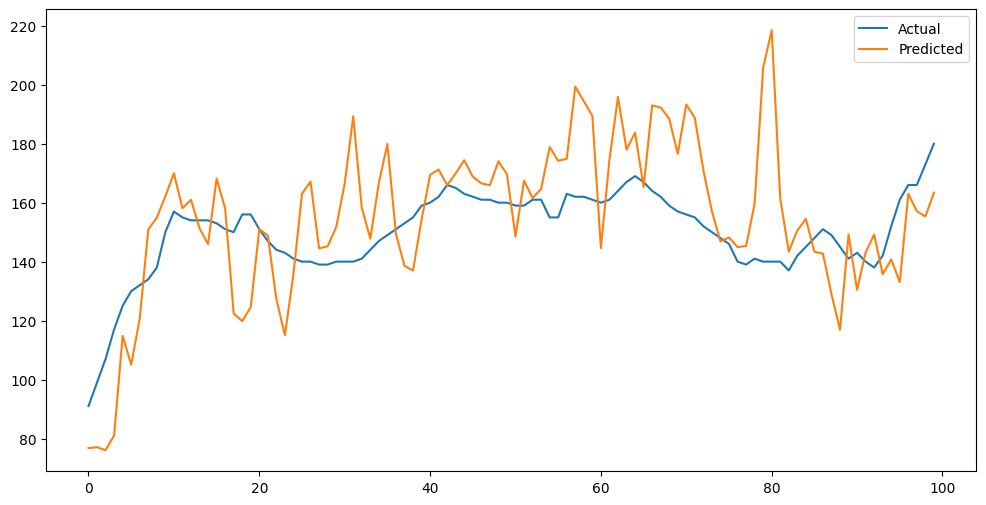

In [ ]:
# plot the prediction
plt.figure(figsize=(12, 6))
plt.plot(actuals[:100], label='Actual')
plt.plot(predictions[:100], label='Predicted')
plt.legend()



In [ ]:
# conver th